1. Install Required Libraries

In [1]:
# Install MediaPipe and OpenCV
!pip install mediapipe opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 44.3 MB/s eta 0:00:00


2. Import Libraries

In [2]:
# Import Libraries
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow


3. Initialize MediaPipe Pose

In [3]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()


4. Define Helper Functions


4.1 Process Image and Extract Landmarks

In [4]:
# Function to Process Image and Extract Landmarks
def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    return results.pose_landmarks, image


4.2 Calculate Angle Between Three Points

In [5]:
# Function to Calculate Angle Between Three Points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    if np.linalg.norm(ba) == 0 or np.linalg.norm(bc) == 0:
        return 0  # Default angle for invalid vectors
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)


4.3 Calculate Vertical Distance

In [6]:
# Function to Calculate Vertical Distance Between Two Points
def calculate_vertical_distance(point1, point2):
    return abs(point1[1] - point2[1])


4.4 Fetch Valid Keypoint

In [7]:
# Function to Fetch Valid Keypoint
def get_valid_keypoint(lm, index, image_width, image_height):
    if index >= len(lm):
        return [0, 0]  # Default point
    keypoint = lm[index]
    return [keypoint.x * image_width, keypoint.y * image_height]


5. Pose Detection Logic

5.1 Detect Marjaryasana (Cat Pose)

In [8]:
# Adjusted Function to Check Curved Back, Head Down, Ground Contact, and Straight Lines for Marjaryasana (Cat Pose)
def detect_cat_pose(landmarks, image):
    if landmarks is None:
        return False

    lm = landmarks.landmark
    image_height, image_width, _ = image.shape

    # Fetch Keypoints
    nose = get_valid_keypoint(lm, mp_pose.PoseLandmark.NOSE.value, image_width, image_height)
    left_shoulder = get_valid_keypoint(lm, mp_pose.PoseLandmark.LEFT_SHOULDER.value, image_width, image_height)
    right_shoulder = get_valid_keypoint(lm, mp_pose.PoseLandmark.RIGHT_SHOULDER.value, image_width, image_height)
    left_hip = get_valid_keypoint(lm, mp_pose.PoseLandmark.LEFT_HIP.value, image_width, image_height)
    right_hip = get_valid_keypoint(lm, mp_pose.PoseLandmark.RIGHT_HIP.value, image_width, image_height)
    left_ankle = get_valid_keypoint(lm, mp_pose.PoseLandmark.LEFT_ANKLE.value, image_width, image_height)
    right_ankle = get_valid_keypoint(lm, mp_pose.PoseLandmark.RIGHT_ANKLE.value, image_width, image_height)
    left_wrist = get_valid_keypoint(lm, mp_pose.PoseLandmark.LEFT_WRIST.value, image_width, image_height)
    right_wrist = get_valid_keypoint(lm, mp_pose.PoseLandmark.RIGHT_WRIST.value, image_width, image_height)
    left_knee = get_valid_keypoint(lm, mp_pose.PoseLandmark.LEFT_KNEE.value, image_width, image_height)
    right_knee = get_valid_keypoint(lm, mp_pose.PoseLandmark.RIGHT_KNEE.value, image_width, image_height)

    # Calculate Vertical Distance Between Nose and Left Shoulder (for head down detection)
    vertical_distance_nose_shoulder = calculate_vertical_distance(nose, left_shoulder)

    # Adjust the head-down condition based on more flexible criteria
    is_head_down = vertical_distance_nose_shoulder > 10  # Adjusted to a lower threshold for more flexibility

    # Calculate Back Angle
    back_angle = calculate_angle(left_shoulder, left_hip, left_ankle)

    # Check if Hands, Knees, and Feet are on the Ground
    is_left_hand_on_ground = left_wrist[1] > left_shoulder[1] and left_wrist[1] > left_hip[1]
    is_right_hand_on_ground = right_wrist[1] > right_shoulder[1] and right_wrist[1] > right_hip[1]

    # Feet on the floor
    is_left_foot_on_ground = left_ankle[1] > left_hip[1]  # Left ankle lower than hip
    is_right_foot_on_ground = right_ankle[1] > right_hip[1]  # Right ankle lower than hip

    # Check if Left Hand, Knee, and Foot form a straight line
    left_hand_knee_foot_angle = calculate_angle(left_wrist, left_knee, left_ankle)
    is_left_hand_knee_foot_straight = 170 < left_hand_knee_foot_angle < 190  # Close to 180 degrees

    # Check if Right Hand, Knee, and Foot form a straight line
    right_hand_knee_foot_angle = calculate_angle(right_wrist, right_knee, right_ankle)
    is_right_hand_knee_foot_straight = 170 < right_hand_knee_foot_angle < 190  # Close to 180 degrees

    # Apply Rules for Marjaryasana Detection
    is_back_curved = 130 < back_angle < 160  # More curved back range
    are_hands_and_feet_on_ground = is_left_hand_on_ground and is_right_hand_on_ground and \
                                    is_left_foot_on_ground and is_right_foot_on_ground
    is_straight_lines = is_left_hand_knee_foot_straight and is_right_hand_knee_foot_straight

    return is_back_curved and is_head_down and are_hands_and_feet_on_ground and is_straight_lines


6. Upload and Test an Image

6.1 Upload Image

In [9]:
# Upload Image for Testing
from google.colab import files
uploaded = files.upload()


Saving mar.jpg to mar.jpg


6.2 Process Image and Detect Pose

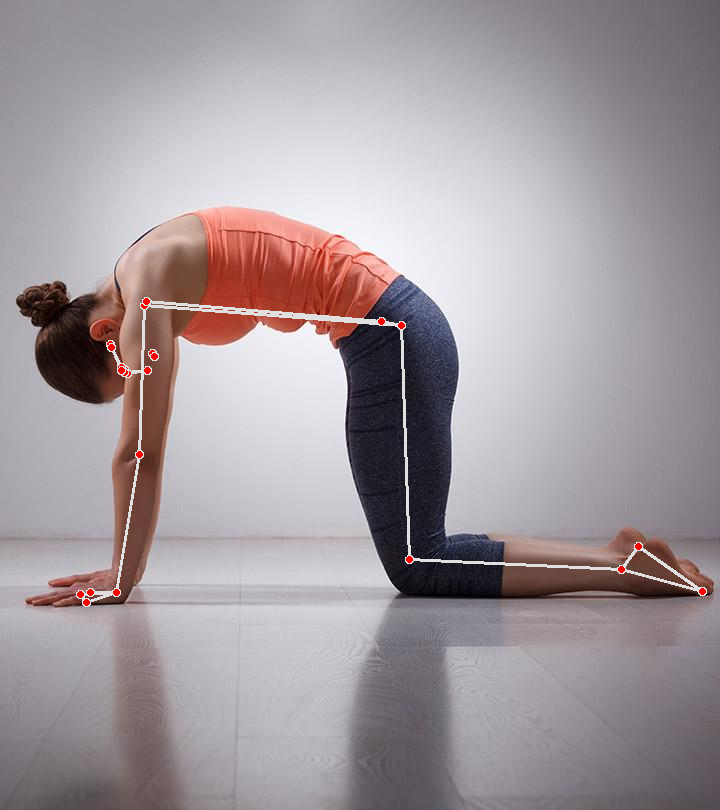

Marjaryasana detected!


In [10]:
# Process the Uploaded Image
for file_name in uploaded.keys():
    landmarks, image = process_image(file_name)

    # Make a copy of the image to avoid modifying the original
    image_copy = image.copy()

    # Draw landmarks on the copy
    if landmarks:
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing.draw_landmarks(image_copy, landmarks, mp_pose.POSE_CONNECTIONS)

    # Show image with landmarks on a fresh copy
    cv2_imshow(image_copy)

    # Perform pose detection (e.g., detect_cat_pose)
    if detect_cat_pose(landmarks, image):
        print("Marjaryasana detected!")
        cv2.putText(image_copy, "Marjaryasana Detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        print("Not Marjaryasana.")
